## Map the ChIP-Atlas TF-peak file to nearest TSS and see if it overlaps with the BEELINE ground truth

The BEELINE paper says that it used TF-TG annotations from ChIP-Atlas for their mESC ChIP-seq dataset. However, they do not specify what files they downloaded or how they mapped peak to target genes. We are validating our TF-peak scoring methods using ChIP-seq TF-peak binding data from ChIP-Atlas, and want to see if the dataset we downloaded matches the BEELINE ground truth.

### ChIP-Atlas data

The ChIP-Atlas dataset we are using can be downloaded from:

`wget https://chip-atlas.dbcls.jp/data/mm10/assembled/Oth.Emb.05.AllAg.AllCell.bed`

This file corresponds to the following settings in the Peak Browser:
- Species -> M. musculus (mm10)
- Track type class -> ChIP: TFs and others
- Cell type class -> Embryo
- Threshold for Significance -> 50
- Track type -> All
- Cell type -> all

### BEELINE Networks

The BEELINE paper's supplementary table 4 contains information about the networks used for their ground truth. The mESC dataset contains the following entry:

| Source | #TFs | #Genes (incl. TFs) | #Edges | Density | Gene expression dataset |
|:------:|:----:|:------------------:|:------:|:-------:|:-----------------------:|
|mESC, ESCAPE+ ChIP-Atlas | 247 | 25,703 | 6,348,394 | 0.154 | mESC, Hayashi et al.^{2} |

2. Hayashi, T. et al. Single-cell full-length total RNA sequencing uncovers dynamics of recursive splicing and enhancer RNAs. Nat. Commun. 9, 619 (2018).

I am also going to re-download the ground truth network from the BEELINE paper to ensure that our RN111 ground truth file and their file are the same.

The `BEELINE-Networks.zip` file containing the `mESC-ChIP-seq-network.csv` file can be downloaded from `https://zenodo.org/records/3701939/files/BEELINE-Networks.zip?download=1`

### Downloading the BEELINE ChIP-seq network for mESC

In [1]:
!hostnamectl

   Static hostname: psh01com1hcom37
         Icon name: computer-server
           Chassis: server
        Machine ID: a0e3b195026b4efbba9be5cc7fb6b874
           Boot ID: ae5b7b962cc94cd09ec7e54c81aed21f
  Operating System: ]8;;https://www.redhat.com/Red Hat Enterprise Linux 8.10 (Ootpa)]8;;
       CPE OS Name: cpe:/o:redhat:enterprise_linux:8::baseos
            Kernel: Linux 4.18.0-553.22.1.el8_10.x86_64
      Architecture: x86-64


In [2]:
GROUND_TRUTH_DIR="/gpfs/Labs/Uzun/SCRIPTS/PROJECTS/2024.SINGLE_CELL_GRN_INFERENCE.MOELLER/ground_truth_files"

# !wget "https://zenodo.org/records/3701939/files/BEELINE-Networks.zip?download=1" -O "$GROUND_TRUTH_DIR/beeline_networks.zip"
# !unzip "$GROUND_TRUTH_DIR/beeline_networks.zip" -d "$GROUND_TRUTH_DIR/beeline_networks"
# !mv "$GROUND_TRUTH_DIR/beeline_networks/Networks/mouse/mESC-ChIP-seq-network.csv" "$GROUND_TRUTH_DIR/mESC_beeline_ChIP-seq.csv"
# !rm -rf "$GROUND_TRUTH_DIR/beeline_networks"
# !rm "$GROUND_TRUTH_DIR/beeline_networks.zip"

In [3]:
import os
import pandas as pd
import csv
import pybedtools

ground_truth_dir = "/gpfs/Labs/Uzun/SCRIPTS/PROJECTS/2024.SINGLE_CELL_GRN_INFERENCE.MOELLER/ground_truth_files"

mesc_rn111_path = "/gpfs/Labs/Uzun/DATA/PROJECTS/2024.SC_MO_TRN_DB.MIRA/REPOSITORY/CURRENT/REFERENCE_NETWORKS/RN111_ChIPSeq_BEELINE_Mouse_ESC.tsv"
chip_atlas_bed_file = os.path.join(ground_truth_dir, "Oth.Emb.05.AllAg.AllCell.bed")
chip_atlas_path = os.path.join(ground_truth_dir, "chipatlas_mESC.csv")
beeline_path = os.path.join(ground_truth_dir, "mESC_beeline_ChIP-seq.csv")

## Comparing BEELINE to mESC RN111

In [4]:
mesc_rn111 = pd.read_csv(mesc_rn111_path, sep='\t', quoting=csv.QUOTE_NONE, on_bad_lines='skip', header=0)
mesc_rn111 = mesc_rn111.rename(columns={"Source": "source_id", "Target": "target_id"})
mesc_rn111 = mesc_rn111[["source_id", "target_id"]]
mesc_rn111.head()

,source_id,target_id
0,ADNP,MIS18BP1
1,ADNP,EXD1
2,ADNP,CHP1
3,ADNP,OSCAR
4,ADNP,NDUFA3


In [5]:
beeline = pd.read_csv(beeline_path)
beeline = beeline.rename(columns={"Gene1": "source_id", "Gene2": "target_id"})
beeline.head()

,source_id,target_id
0,ADNP,MIS18BP1
1,ADNP,EXD1
2,ADNP,CHP1
3,ADNP,OSCAR
4,ADNP,NDUFA3


In [6]:
merged_df = pd.merge(beeline, mesc_rn111, on=["source_id", "target_id"], how="outer", indicator=True)
beeline_only = len(merged_df[merged_df["_merge"] == "left_only"])
rn111_only = len(merged_df[merged_df["_merge"] == "right_only"])
both = len(merged_df[merged_df["_merge"] == "both"])
print(f"Edges only in BEELINE {beeline_only}")
print(f"Edges only in RN111 {rn111_only}")
print(f"Edges present in both {both}")

Edges only in BEELINE 7
Edges only in RN111 7
Edges present in both 977834


7 of the edges were not found in both datasets. However, looking more closely this is because the BEELINE dataset had multiple gene names separated by a comma and they were mis-handled when the gene names were standardized

In [7]:
merged_df[merged_df["_merge"] == "left_only"]

,source_id,target_id,_merge
199714,EZH2,"CHAT,SLC18A3",left_only
200282,EZH2,"D930049A15RIK,ZMIZ1",left_only
202114,EZH2,"H2-T3,H2-TW3",left_only
662511,RNF2,"CHAT,SLC18A3",left_only
663173,RNF2,"D930049A15RIK,ZMIZ1",left_only
769785,SUZ12,"CHAT,SLC18A3",left_only
770330,SUZ12,"D930049A15RIK,ZMIZ1",left_only


In [8]:
merged_df[merged_df["_merge"] == "right_only"]

,source_id,target_id,_merge
197850,EZH2,"""CHAT",right_only
197851,EZH2,"""D930049A15RIK",right_only
197852,EZH2,"""H2-T3",right_only
660210,RNF2,"""CHAT",right_only
660211,RNF2,"""D930049A15RIK",right_only
767669,SUZ12,"""CHAT",right_only
767670,SUZ12,"""D930049A15RIK",right_only


All of edges are the same between BEELINE and RN111.

## Comparing ChIP-Atlas to BEELINE

First, we need to map the peaks in the ChIP-Atlas bed file to the nearest gene TSS for each peak.

The mm10 tss_reference_file can be downloaded from here:

[RefGenie mm10 TSS annotation file](http://awspds.refgenie.databio.org/refgenomes.databio.org/0f10d83b1050c08dd53189986f60970b92a315aa7a16a6f1/ensembl_gtf__default/0f10d83b1050c08dd53189986f60970b92a315aa7a16a6f1_ensembl_gene_body.bed)

In [4]:

chip_bed = pybedtools.BedTool(chip_atlas_bed_file)
tss_bed = pybedtools.BedTool("/gpfs/Labs/Uzun/SCRIPTS/PROJECTS/2024.SINGLE_CELL_GRN_INFERENCE.MOELLER/data/genome_annotation/mm10/mm10_TSS.bed")
chip_closest_tss = chip_bed.closest(tss_bed, d=True)

We need to extract the TF name from the index and the TG name from the `tss_gene` column

In [5]:
raw_chip_closest_tss_df = chip_closest_tss.to_dataframe(
    names=["peak_chr", "peak_start", "peak_end", "peak_gene",
           "tss_chr", "tss_start", "tss_end", "tss_gene", "strand", "strand2", "distance"]
)

raw_chip_closest_tss_df = raw_chip_closest_tss_df.reset_index()
raw_chip_closest_tss_df["source_id"] = (
    raw_chip_closest_tss_df["level_3"]
    .str.extract(r'Name=([^%]+)')
)

In [6]:
raw_chip_closest_tss_df.head()

,level_0,level_1,level_2,level_3,level_4,peak_chr,peak_start,peak_end,peak_gene,tss_chr,tss_start,tss_end,tss_gene,strand,strand2,distance,source_id
0,chr1,3003564,3003922,ID=SRX4061019;Name=Smad4%20(@%20Forelimb);Titl...,72,.,3003564,3003922,"0,73,255",chr1,3671498,3671498,Xkr4,.,-,667576,Smad4
1,chr1,3012605,3012815,ID=SRX20144584;Name=Ctcf%20(@%20Embryonic%20br...,141,.,3012605,3012815,"0,143,255",chr1,3671498,3671498,Xkr4,.,-,658683,Ctcf
2,chr1,3012635,3012824,ID=SRX23715619;Name=Ctcf%20(@%20Embryonic%20br...,147,.,3012635,3012824,"0,149,255",chr1,3671498,3671498,Xkr4,.,-,658674,Ctcf
3,chr1,3031387,3031654,ID=SRX663359;Name=Epitope%20tags%20(@%20Embryo...,117,.,3031387,3031654,"0,119,255",chr1,3671498,3671498,Xkr4,.,-,639844,Epitope
4,chr1,3031454,3031677,ID=SRX4061019;Name=Smad4%20(@%20Forelimb);Titl...,177,.,3031454,3031677,"0,180,255",chr1,3671498,3671498,Xkr4,.,-,639821,Smad4


In [11]:
raw_chip_closest_tss_df["peak_id"] = raw_chip_closest_tss_df["level_0"].astype(str) + ":" + raw_chip_closest_tss_df["level_1"].astype(str) + "-" + raw_chip_closest_tss_df["level_2"].astype(str)

In [12]:
raw_chip_closest_tss_df.head()

,level_0,level_1,level_2,level_3,level_4,peak_chr,peak_start,peak_end,peak_gene,tss_chr,tss_start,tss_end,tss_gene,strand,strand2,distance,source_id,peak_id
0,chr1,3003564,3003922,ID=SRX4061019;Name=Smad4%20(@%20Forelimb);Titl...,72,.,3003564,3003922,"0,73,255",chr1,3671498,3671498,Xkr4,.,-,667576,Smad4,chr1:3003564-3003922
1,chr1,3012605,3012815,ID=SRX20144584;Name=Ctcf%20(@%20Embryonic%20br...,141,.,3012605,3012815,"0,143,255",chr1,3671498,3671498,Xkr4,.,-,658683,Ctcf,chr1:3012605-3012815
2,chr1,3012635,3012824,ID=SRX23715619;Name=Ctcf%20(@%20Embryonic%20br...,147,.,3012635,3012824,"0,149,255",chr1,3671498,3671498,Xkr4,.,-,658674,Ctcf,chr1:3012635-3012824
3,chr1,3031387,3031654,ID=SRX663359;Name=Epitope%20tags%20(@%20Embryo...,117,.,3031387,3031654,"0,119,255",chr1,3671498,3671498,Xkr4,.,-,639844,Epitope,chr1:3031387-3031654
4,chr1,3031454,3031677,ID=SRX4061019;Name=Smad4%20(@%20Forelimb);Titl...,177,.,3031454,3031677,"0,180,255",chr1,3671498,3671498,Xkr4,.,-,639821,Smad4,chr1:3031454-3031677


In [13]:
raw_chip_closest_tss_df["source_id"] = raw_chip_closest_tss_df["source_id"].str.upper()
raw_chip_closest_tss_df["peak_id"] = raw_chip_closest_tss_df["level_0"].astype(str) + ":" + raw_chip_closest_tss_df["level_1"].astype(str) + "-" + raw_chip_closest_tss_df["level_2"].astype(str)
raw_chip_closest_tss_df["target_id"] = raw_chip_closest_tss_df["tss_gene"].str.upper()

chip_closest_tss_df = raw_chip_closest_tss_df[["source_id", "peak_id", "target_id", "distance"]]
chip_closest_tss_df

,source_id,peak_id,target_id,distance
0,SMAD4,chr1:3003564-3003922,XKR4,667576
1,CTCF,chr1:3012605-3012815,XKR4,658683
2,CTCF,chr1:3012635-3012824,XKR4,658674
3,EPITOPE,chr1:3031387-3031654,XKR4,639844
4,SMAD4,chr1:3031454-3031677,XKR4,639821
...,...,...,...,...
7734461,REST,chrY_JH584303_random:135985-136047,.,-1
7734462,REST,chrY_JH584303_random:135985-136048,.,-1
7734463,REST,chrY_JH584303_random:135986-136045,.,-1
7734464,REST,chrY_JH584303_random:135989-136043,.,-1


In [15]:
chip_closest_tss_df.to_csv(os.path.join(GROUND_TRUTH_DIR, "chip_atlas_tf_peak_tg_dist.csv"), header=True, index=False)

We next need to filter both the BEELINE and ChIP-Atlas dataset for edges containing genes that are present in both datasets. This filtering helps us to compare the *connections* between shared genes, as we cannot determine whether genes unique to one dataset would have the same edges if that gene were present in the other dataset.

In [18]:
valid_targets = set(beeline["target_id"]) & set(chip_closest_tss_df["target_id"])
valid_sources = set(beeline["source_id"]) & set(chip_closest_tss_df["source_id"])

beeline_shared_genes = beeline[
    beeline["source_id"].isin(valid_sources) &
    beeline["target_id"].isin(valid_targets)
]

chip_shared_genes = chip_closest_tss_df[
    chip_closest_tss_df["source_id"].isin(valid_sources) &
    chip_closest_tss_df["target_id"].isin(valid_targets)
]

# The distance column will keep duplicate edges with different peak to TSS distances
chip_shared_genes = chip_shared_genes.drop(columns="distance").drop_duplicates()

In [19]:
merged_df = pd.merge(
    beeline_shared_genes, 
    chip_shared_genes, 
    on=["source_id", "target_id"], 
    how="outer", 
    indicator=True
    )

beeline_only = merged_df[merged_df["_merge"] == "left_only"]
chip_atlas_only = merged_df[merged_df["_merge"] == "right_only"]
both = merged_df[merged_df["_merge"] == "both"]

print(f"Edges only in BEELINE {len(beeline_only):,}")
print(f"Edges only in ChIP-Atlas {len(chip_atlas_only):,}")
print(f"Edges present in both {len(both):,}")

Edges only in BEELINE 149,523
Edges only in ChIP-Atlas 115,704
Edges present in both 72,204


### Comparing Peak to TSS Distance for Shared vs ChIP-Atlas Only Edges

Since there is little overlap, do we see a difference in the groups based on distance to TSS? First, lets re-create the merged_df without dropping the distance column from ChIP-Atlas.

In [20]:
beeline_shared_genes = beeline[
    beeline["source_id"].isin(valid_sources) &
    beeline["target_id"].isin(valid_targets)
]

chip_shared_genes = chip_closest_tss_df[
    chip_closest_tss_df["source_id"].isin(valid_sources) &
    chip_closest_tss_df["target_id"].isin(valid_targets)
]

merged_df = pd.merge(
    beeline_shared_genes, 
    chip_shared_genes, 
    on=["source_id", "target_id"], 
    how="outer", 
    indicator=True
    )

beeline_only = merged_df[merged_df["_merge"] == "left_only"]
chip_atlas_only = merged_df[merged_df["_merge"] == "right_only"]
both = merged_df[merged_df["_merge"] == "both"]

print(f"Edges only in BEELINE {len(beeline_only):,}")
print(f"Edges only in ChIP-Atlas {len(chip_atlas_only):,}")
print(f"Edges present in both {len(both):,}")

Edges only in BEELINE 149,523
Edges only in ChIP-Atlas 2,102,297
Edges present in both 1,721,462


In [21]:
shared_edge_distance = both["distance"].rename("Edge in ChIP-Atlas and BEELINE").reset_index(drop=True)
chip_atlas_only_distance = chip_atlas_only["distance"].rename("Edge in ChIP-Atlas Only").reset_index(drop=True)
tss_distance_by_shared_edge_df = pd.merge(
    shared_edge_distance,
    chip_atlas_only_distance,
    left_index=True,
    right_index=True
)

Text(0.5, 1.0, 'ChIP-Atlas Peak to TSS Distance')

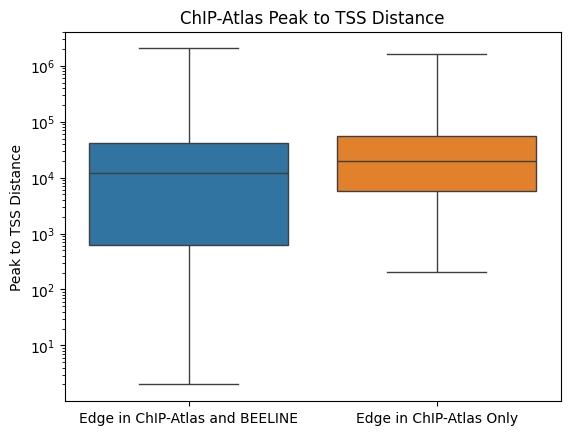

In [22]:
import seaborn as sns
import matplotlib.pyplot as plt

fig = plt.Figure()
a = sns.boxplot(data=tss_distance_by_shared_edge_df, log_scale=True, showfliers=False)
a.set_ylabel("Peak to TSS Distance")
a.set_title("ChIP-Atlas Peak to TSS Distance")

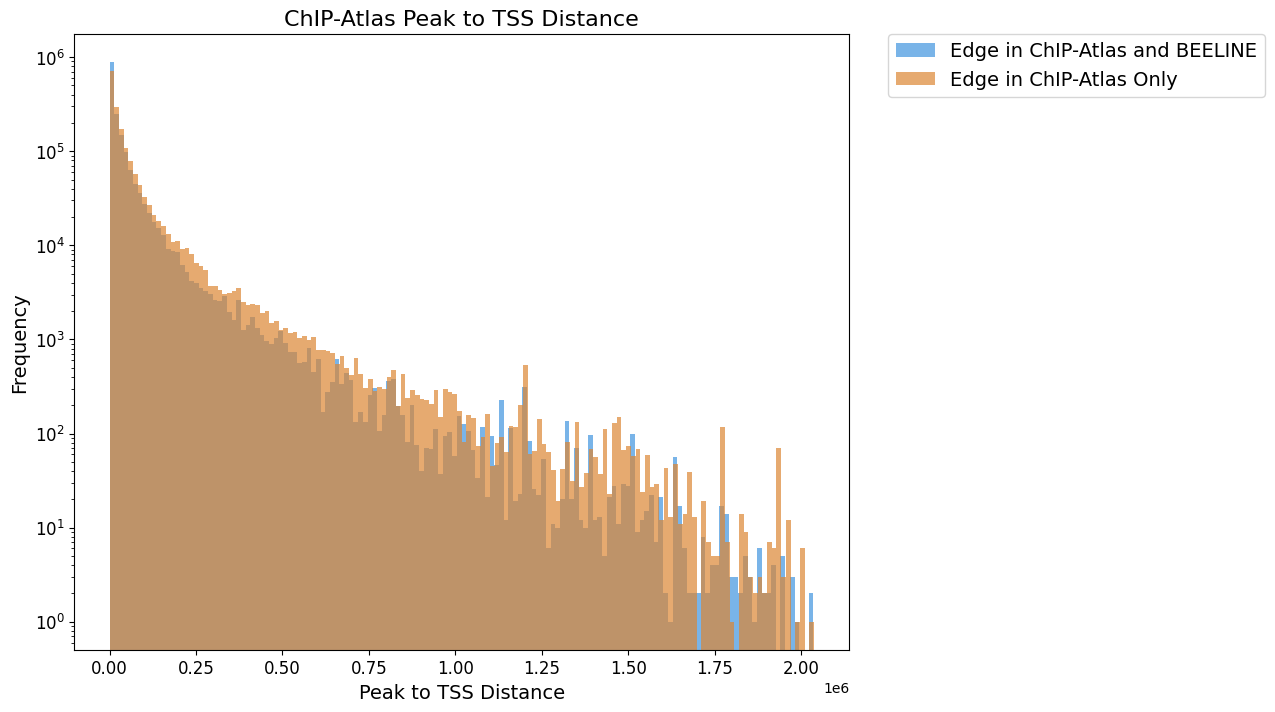

In [23]:
plt.figure(figsize=(10,8))
plt.hist(
    tss_distance_by_shared_edge_df["Edge in ChIP-Atlas and BEELINE"],
    bins=150,
    alpha=0.7,
    color='#4195df',
    label="Edge in ChIP-Atlas and BEELINE",
    log=True
)
plt.hist(
    tss_distance_by_shared_edge_df["Edge in ChIP-Atlas Only"],
    bins=150,
    alpha=0.7,
    color='#dc8634',
    label="Edge in ChIP-Atlas Only",
    log=True
)
plt.title("ChIP-Atlas Peak to TSS Distance", fontsize=16)
plt.xlabel("Peak to TSS Distance", fontsize=14)
plt.ylabel("Frequency", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0., fontsize=14)

Peak to TSS distance does not seem to be different between the shared edges and edges only in ChIP-Atlas.

### Subsetting ChIP-Atlas to only use peaks that are shared with BEELINE

We have been using the BEELINE ChIP-seq dataset as the ground truth for testing our GRN inference method. Since we do not have peaks for the BEELINE edges, I can subset the ChIP-Atlas by the shared edges to get peak locations for BEELINE.

In [24]:
raw_chip_closest_tss_df

,level_0,level_1,level_2,level_3,level_4,peak_chr,peak_start,peak_end,peak_gene,tss_chr,tss_start,tss_end,tss_gene,strand,strand2,distance,source_id,target_id
0,chr1,3003564,3003922,ID=SRX4061019;Name=Smad4%20(@%20Forelimb);Titl...,72,.,3003564,3003922,"0,73,255",chr1,3671498,3671498,Xkr4,.,-,667576,SMAD4,XKR4
1,chr1,3012605,3012815,ID=SRX20144584;Name=Ctcf%20(@%20Embryonic%20br...,141,.,3012605,3012815,"0,143,255",chr1,3671498,3671498,Xkr4,.,-,658683,CTCF,XKR4
2,chr1,3012635,3012824,ID=SRX23715619;Name=Ctcf%20(@%20Embryonic%20br...,147,.,3012635,3012824,"0,149,255",chr1,3671498,3671498,Xkr4,.,-,658674,CTCF,XKR4
3,chr1,3031387,3031654,ID=SRX663359;Name=Epitope%20tags%20(@%20Embryo...,117,.,3031387,3031654,"0,119,255",chr1,3671498,3671498,Xkr4,.,-,639844,EPITOPE,XKR4
4,chr1,3031454,3031677,ID=SRX4061019;Name=Smad4%20(@%20Forelimb);Titl...,177,.,3031454,3031677,"0,180,255",chr1,3671498,3671498,Xkr4,.,-,639821,SMAD4,XKR4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7734461,chrY_JH584303_random,135985,136047,ID=SRX11249167;Name=Rest%20(@%20Embryonic%20pa...,530,.,135985,136047,"30,255,0",.,-1,-1,.,-1,.,-1,REST,.
7734462,chrY_JH584303_random,135985,136048,ID=SRX11249163;Name=Rest%20(@%20Embryonic%20pa...,299,.,135985,136048,"0,255,205",.,-1,-1,.,-1,.,-1,REST,.
7734463,chrY_JH584303_random,135986,136045,ID=SRX11249166;Name=Rest%20(@%20Embryonic%20pa...,350,.,135986,136045,"0,255,153",.,-1,-1,.,-1,.,-1,REST,.
7734464,chrY_JH584303_random,135989,136043,ID=SRX11249164;Name=Rest%20(@%20Embryonic%20pa...,227,.,135989,136043,"0,231,255",.,-1,-1,.,-1,.,-1,REST,.


In [25]:
chip_closest_tss_df = raw_chip_closest_tss_df[["source_id", "level_0", "peak_start", "peak_end", "target_id"]]
chip_closest_tss_df = chip_closest_tss_df.rename(columns={
    "level_0":"chrom",
    "peak_start":"start",
    "peak_end":"end"
})

# def format_peak_id(chrom, start, end):
#     return "%s:%s-%s" % (chrom, start, end)

# chip_closest_tss_df["peak_id"] = chip_closest_tss_df.apply(lambda x: format_peak_id(x.level_0, x.peak_start, x.peak_end), axis=1)
# chip_closest_tss_df = chip_closest_tss_df[["source_id", "peak_id", "target_id"]]
chip_closest_tss_df

,source_id,chrom,start,end,target_id
0,SMAD4,chr1,3003564,3003922,XKR4
1,CTCF,chr1,3012605,3012815,XKR4
2,CTCF,chr1,3012635,3012824,XKR4
3,EPITOPE,chr1,3031387,3031654,XKR4
4,SMAD4,chr1,3031454,3031677,XKR4
...,...,...,...,...,...
7734461,REST,chrY_JH584303_random,135985,136047,.
7734462,REST,chrY_JH584303_random,135985,136048,.
7734463,REST,chrY_JH584303_random,135986,136045,.
7734464,REST,chrY_JH584303_random,135989,136043,.


In [26]:
valid_targets = set(beeline["target_id"]) & set(chip_closest_tss_df["target_id"])
valid_sources = set(beeline["source_id"]) & set(chip_closest_tss_df["source_id"])

beeline_shared_genes = beeline[
    beeline["source_id"].isin(valid_sources) &
    beeline["target_id"].isin(valid_targets)
]

chip_shared_genes = chip_closest_tss_df[
    chip_closest_tss_df["source_id"].isin(valid_sources) &
    chip_closest_tss_df["target_id"].isin(valid_targets)
]

merged_df = pd.merge(
    beeline_shared_genes, 
    chip_shared_genes, 
    on=["source_id", "target_id"], 
    how="outer", 
    indicator=True
    ).convert_dtypes(convert_floating=True)

shared_edges = merged_df[merged_df["_merge"] == "both"].drop(columns="_merge")
shared_edges

,source_id,target_id,chrom,start,end
41,ASCL1,ACACB,chr5,114173037,114173222
42,ASCL1,ACACB,chr5,114173103,114173157
173,ASCL1,BTBD17,chr11,114795327,114795552
174,ASCL1,BTBD17,chr11,114795386,114795436
379,ASCL1,DLL3,chr7,28302269,28302413
...,...,...,...,...,...
3973234,ZFP281,ZMYND12,chr4,119422622,119422859
3973237,ZFP281,ZMYND8,chr2,165900305,165900542
3973238,ZFP281,ZMYND8,chr2,165906423,165906828
3973239,ZFP281,ZMYND8,chr2,165922264,165922501


Now that we have a DataFrame containing shared edges between BEELINE and ChIP-Atlas with peak locations, we can save it to the ground truth directory and use it to validate our TF to peak binding methods.

In [27]:
shared_edges.to_csv(os.path.join(ground_truth_dir, "chipatlas_beeline_mESC_shared_edges.csv"), header=True, index=False)